# Imports

In [1]:
import numpy as np
import pandas as pd

import sys

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Define activation functions

In [2]:
def sigmoid(z, derivative=False):
    if derivative:
        return sigmoid(z) * (1 - sigmoid(z) )
    return 1 / (1 + np.exp(-z))

def relu(z, derivative=False):
    if derivative:
        return 1 * (z > 0)
    return z * (z > 0)

def tanh(z, derivative=False):
    if derivative:
        return 1 - tanh(z)**2
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

def linear(z, derivative=False):
    if derivative:
        return 1
    return z

# Data preparation

In [3]:
data_path = '/Users/shoaib/udacityDL/first-neural-network/Bike-Sharing-Dataset//hour.csv'
rides = pd.read_csv(data_path)
target_fields = ['cnt', 'casual', 'registered']
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
rides['dteday'] = pd.to_datetime(rides['dteday'])

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
# 

test_index = (rides['dteday'].dt.year==2012) & (rides['dteday'].dt.month==12)

# TEST Data
# Save data for approximately the last 30 days 
test_data = data[test_index] #data[-30*24:]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
Xts = test_features.values
yts = test_targets['cnt'].values.reshape(Xts.shape[0],1)
print('Test data: ', Xts.shape, yts.shape)

# TRAINING and VALIDATION Data
# Now remove the test data from the data set 
train_val_data = data[~test_index]#data[:-30*24]
# Separate the data into features and targets
train_val_features, train_val_targets = data.drop(target_fields, axis=1), data[target_fields]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = train_val_features[:-60*24], train_val_targets[:-60*24]
val_features, val_targets = train_val_features[-60*24:], train_val_targets[-60*24:]

Xtr = train_features.values
ytr = train_targets['cnt'].values.reshape(Xtr.shape[0],1)
print('Training data: ', Xtr.shape, ytr.shape)

Xval = val_features.values
yval = val_targets['cnt'].values.reshape(Xval.shape[0],1)
print('Validation data: ', Xval.shape, yval.shape)

Test data:  (742, 56) (742, 1)
Training data:  (15939, 56) (15939, 1)
Validation data:  (1440, 56) (1440, 1)


# Initialize parameters

In [4]:
def initialize(n_layer, seed=0):
    W, b, dW, db = {}, {}, {}, {}
    np.random.seed(seed)
    for i in range(n_layer):
        W['L'+str(i)+',L'+str(i+1)] = np.random.normal(0.0, n_nodes[i]**-0.5, (n_nodes[i], n_nodes[i+1]))
        b['L'+str(i+1)] = np.zeros((1,n_nodes[i+1]))
    return W, b

# Forward pass

In [5]:
def forward_propagation(X, W, b, regression=True, predict=False):
    n_layer = len(W)
    z, A = {}, {}
    A['L0'] = X.copy()
    
    # Hidden layers
    for i in range(n_layer-1):
        z['L'+str(i+1)] = np.matmul(A['L'+str(i)],W['L'+str(i)+',L'+str(i+1)]) + b['L'+str(i+1)]
        A['L'+str(i+1)] = relu(z['L'+str(i+1)])
    
    # Output layer
    z['L'+str(n_layer)] = np.matmul(A['L'+str(n_layer-1)],W['L'+str(n_layer-1)+',L'+str(n_layer)]) + b['L'+str(n_layer)]
    if regression:
        A['L'+str(n_layer)] = linear(z['L'+str(n_layer)])
    else:
        A['L'+str(n_layer)] = sigmoid(z['L'+str(n_layer)])
        
    if predict:
        return A['L'+str(n_layer)]
    
    return z, A

# Backpropagation

In [6]:
def backpropagation(A, y, z, W, b, dW, db):
    n_layer = len(W)
    E, EP = {}, {}
    
    # Output layer
    E['L'+str(n_layer)] = y - A['L'+str(n_layer)] # output error
    EP['L'+str(n_layer)] = E['L'+str(n_layer)] * linear(z['L'+str(n_layer)], derivative=True) # output error term
    dW['L'+str(n_layer-1)+',L'+str(n_layer)] += np.matmul(A['L'+str(n_layer-1)].T, EP['L'+str(n_layer)]) # output weight change
    db['L'+str(n_layer)] += 0 * np.mean(EP['L'+str(n_layer)], axis=0)
    # Hidden layers
    n_hidden_layer = n_layer - 1
    for i in range(n_hidden_layer,0,-1):
        E['L'+str(i)] = np.matmul( EP['L'+str(i+1)], W['L'+str(i)+',L'+str(i+1)].T)
        EP['L'+str(i)] = E['L'+str(i)] * relu(z['L'+str(i)], derivative=True)
        dW['L'+str(i-1)+',L'+str(i)] += np.matmul(A['L'+str(i-1)].T, EP['L'+str(i)])
        db['L'+str(i)] += 0 * np.mean(EP['L'+str(i)], axis = 0)
    
    return dW, db

# Update parameters

In [7]:
def update(W, b, dW, db, learning_rate, n_records):
    for i in range(n_layer, 0, -1):
        W['L'+str(i-1)+',L'+str(i)] += learning_rate * dW['L'+str(i-1)+',L'+str(i)] / n_records
        b['L'+str(i)] += learning_rate * db['L'+str(i)]
    #print(W['L0,L1'],'------\n', W['L1,L2'])
    return W, b

# Train a singel batch of data

In [8]:
def batch_train(X, y, W, b, learning_rate):
    n_records, n_features = X.shape
    
    dW, db = {}, {}
    for key in W:
        dW[key] = np.zeros(W[key].shape)
    for key in b:
        db[key] = 0
    
    for i in range(n_records):
        Xi = X[i,:].reshape(1,n_features)
        yi = y[i].reshape(1,1)
        z, A = forward_propagation(Xi, W, b)
        dW, db = backpropagation(A, yi, z, W, b, dW, db)
    W, b = update(W, b, dW, db, learning_rate, n_records)
        
    return W, b

# Define a loss function

In [9]:
def compute_mse(y, yh):
    mse = np.matmul((y-yh).T,(y-yh)) / y.shape[0]
    return mse[0]

# Train and validate the model

In [10]:
n_search = 1

history, hyperparameters, parameters, metrics = {}, {}, {}, {}
min_loss = np.infty

for isearch in range(n_search):
    # Pick random hyperparameters
    learning_rate = np.random.choice([1.0])
    n_hidden_layer = np.random.choice([2])
    n_hidden_layer_nodes = [15,20] #np.random.choice([15,20],n_hidden_layer)
    batch_size = np.random.choice([64])
    n_epochs = np.random.choice([1000])
    learning_rate_decay = 1.1
    
    initial_learning_rate = learning_rate
    
    # Network information
    n_layer = n_hidden_layer + 1
    (n_records, n_features), n_target = Xtr.shape, ytr.shape[1]
    n_nodes = [n_features] + list(n_hidden_layer_nodes) + [n_target]
    
    
    # Training
    train_loss = np.zeros(n_epochs)
    val_loss = np.zeros(n_epochs)

    W, b = initialize(n_layer)
    for iepoch in range(n_epochs):
        np.random.seed(iepoch)
        batch = np.random.choice(Xtr.shape[0], size=batch_size)
        Xbatch, ybatch = Xtr[batch,:], ytr[batch,0]

        if iepoch%100 == 0:
            learning_rate = learning_rate / 1.1

        W, b = batch_train(Xbatch, ybatch, W, b, learning_rate=learning_rate)

        # Compute loss
        ytr_pred = forward_propagation(Xtr, W, b, predict=True)
        yval_pred = forward_propagation(Xval, W, b, predict=True)
        train_loss[iepoch] = compute_mse(ytr, ytr_pred)
        val_loss[iepoch] = compute_mse(yval, yval_pred)

        sys.stdout.write("\rProgress: {:2.1f}".format(100 * (iepoch+1)/float(n_epochs)) \
                                 + "% ... Training loss: " + str(train_loss[iepoch])[:5] \
                                 + " ... Validation loss: " + str(val_loss[iepoch])[:5])
        sys.stdout.flush()
    print()
    if val_loss[iepoch] < min_loss:
        min_loss = val_loss[iepoch]
        
        hyperparameters['learning_rate'] = initial_learning_rate
        hyperparameters['learning_rate_decay'] = learning_rate_decay
        hyperparameters['n_hidden_layer'] = n_hidden_layer
        hyperparameters['n_hidden_layer_nodes'] = list(n_hidden_layer_nodes)
        hyperparameters['batch_size'] = batch_size
        
        parameters['W'] = W
        parameters['b'] = b
        
        metrics['train_loss'] = train_loss
        metrics['val_loss'] = val_loss
        
        history['hyperparameters'] = hyperparameters
        history['parameters'] = parameters
        history['metrics'] = metrics
        
    # history['train_loss'] = train_loss

Progress: 100.0% ... Training loss: 0.061 ... Validation loss: 0.134


# Visualize training history

In [11]:
history['hyperparameters']
# history['parameters']['b']

{'batch_size': 64,
 'learning_rate': 1.0,
 'learning_rate_decay': 1.1,
 'n_hidden_layer': 2,
 'n_hidden_layer_nodes': [15, 20]}

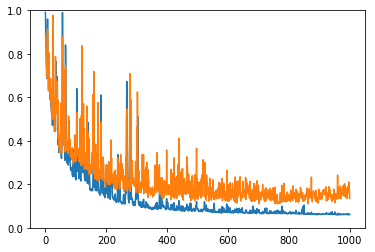

In [13]:
plt.plot(history['metrics']['train_loss'])
plt.plot(history['metrics']['val_loss'])
plt.ylim([0,1])
plt.show()

# Testing

In [14]:
# Parameters
W = history['parameters']['W']
b = history['parameters']['b']

yh = forward_propagation(Xts, W, b, predict=True)

mean, std = scaled_features['cnt']
yts_pred = yh * std + mean
yts_pred[yts_pred < 0] = 0
yts_true = yts * std + mean

print(compute_mse(yts_true, yts_pred))

[3656.60412968]


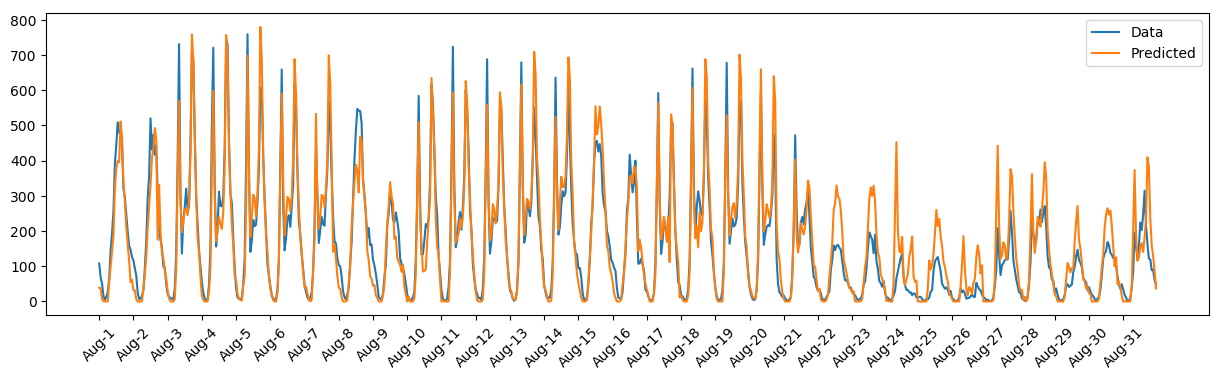

In [15]:
days = np.unique(rides['dteday'][test_index].dt.day)
days_index = [np.where( rides['dteday'][test_index].dt.day == day )[0][0] for day in days]
days = ['Aug-'+str(day) for day in days]

plt.figure(figsize=(15,4), dpi=100)
plt.plot(yts_true)
plt.plot(yts_pred)
plt.xticks(days_index, days, rotation=45, horizontalalignment='center')

plt.legend(['Data','Predicted'])
plt.show()